# 모듈 임포트 및 데이터 로드

In [1]:
!pip install prophet

In [2]:
!pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.6 MB/s eta 0:00:00


In [3]:
from tqdm.auto import tqdm
import random
import os

import torch

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import numpy as np
import pandas as pd

In [4]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

reset_seeds()

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
!pip install -U finance-datareader

In [7]:
import FinanceDataReader as fdr

In [8]:
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,73300,1,200,0.27,73800,74000,73200,15419815,1134484297093,437585060915000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,140000,1,3300,2.41,137000,140000,137000,5011719,698129501600,101920331100000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,422000,2,-500,-0.12,426500,431000,422000,341008,144990527500,98748000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,703000,1,5000,0.72,702000,705000,700000,59749,41991591000,50035322000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,59300,2,-600,-1.00,59900,60100,59300,1609498,95959015300,48797181310000,822886700,STK


In [9]:
df_kospi = df_krx[df_krx['Market'] == 'KOSPI']
df_kospi

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,73300,1,200,0.27,73800,74000,73200,15419815,1134484297093,437585060915000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,140000,1,3300,2.41,137000,140000,137000,5011719,698129501600,101920331100000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,422000,2,-500,-0.12,426500,431000,422000,341008,144990527500,98748000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,703000,1,5000,0.72,702000,705000,700000,59749,41991591000,50035322000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,59300,2,-600,-1.00,59900,60100,59300,1609498,95959015300,48797181310000,822886700,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,002785,KR7002781003,진흥기업우B,KOSPI,,5020,1,25,0.50,4990,5040,4895,548,2692490,4303234360,857218,STK
2773,014915,KR7014911002,성문전자우,KOSPI,,6730,2,-350,-4.94,7540,7540,6700,3076,21072330,4038000000,600000,STK
2774,001525,KR7001521004,동양우,KOSPI,,6150,1,30,0.49,6120,6290,6060,1172,7220820,3799045650,617731,STK
2777,002787,KR7002782001,진흥기업2우B,KOSPI,,12750,1,160,1.27,12610,12750,12470,105,1394450,3758802000,294808,STK


In [11]:
def get_stock_data(item_name, year=2020):
    df_krx = fdr.StockListing('KRX')
    df_kospi = df_krx[df_krx['Market'] == 'KOSPI']

    def item_code_by_item_name(item_name):
        item_code_list = df_kospi.loc[df_kospi["Name"] == item_name, "Code"].tolist()
        if len(item_code_list) > 0:
            item_code = item_code_list[0]
            return item_code
        else:
            return None

    def find_item_list(item_name, year=2020):
        item_code = item_code_by_item_name(item_name)
        if item_code:
            df_day = fdr.DataReader(item_code, str(year))
            return df_day
        else:
            return None

    df = find_item_list(item_name, year)
    return df

# 모델 세팅 및 학습, 예측

In [14]:
def preprocess_data(df):
    data = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

def train_prophet_model(df, days_to_predict):
    df['ds'] = pd.to_datetime(df.index)
    df['y'] = df['Close']

    model = Prophet(daily_seasonality=True)
    model.fit(df[['ds', 'y']])

    future = model.make_future_dataframe(periods=days_to_predict)
    forecast = model.predict(future)

    return model, forecast

def plot_prophet_forecast(model, forecast):
    model.plot(forecast)
    plt.show()

def save_forecast_to_dataframe(df, forecast, stock_name):
    forecast_df = forecast[['ds', 'yhat']].tail(14).rename(columns={'ds': 'Date', 'yhat': 'Predicted_Close'})
    forecast_df['Stock'] = stock_name
    return forecast_df

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6i6a_n45/kigmr21j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6i6a_n45/ndfm562o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52385', 'data', 'file=/tmp/tmp6i6a_n45/kigmr21j.json', 'init=/tmp/tmp6i6a_n45/ndfm562o.json', 'output', 'file=/tmp/tmp6i6a_n45/prophet_modeligm5eyld/prophet_model-20231217130906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


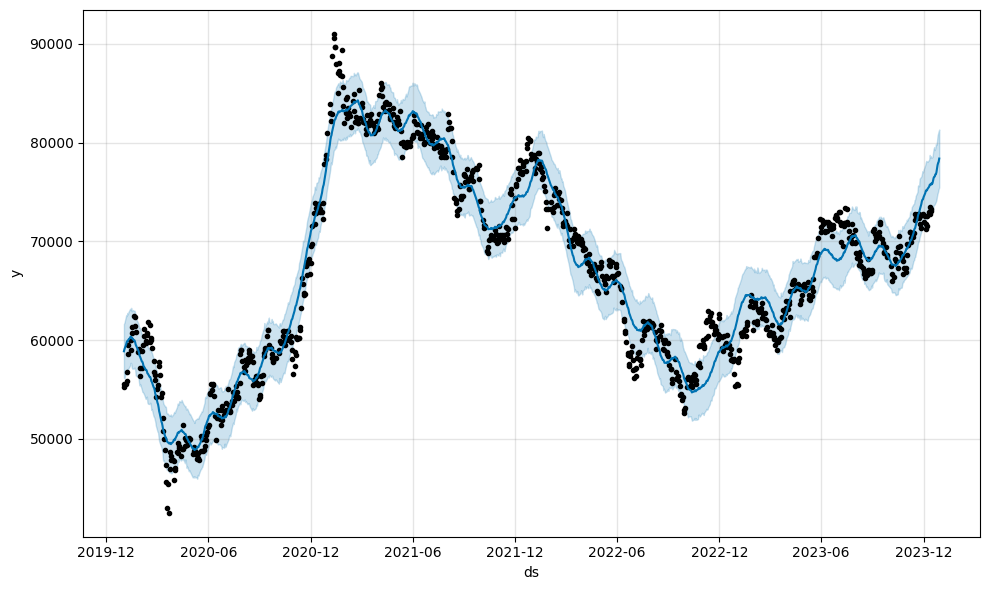

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6i6a_n45/4a3ie4j8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6i6a_n45/jgnpit16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90888', 'data', 'file=/tmp/tmp6i6a_n45/4a3ie4j8.json', 'init=/tmp/tmp6i6a_n45/jgnpit16.json', 'output', 'file=/tmp/tmp6i6a_n45/prophet_modelyblbel3b/prophet_model-20231217130910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


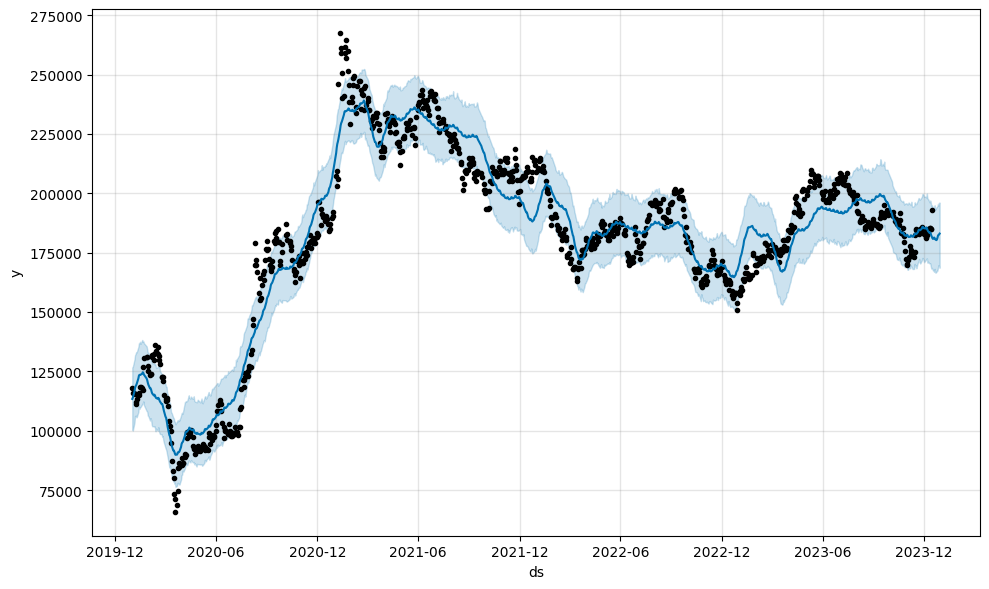

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6i6a_n45/4he_1zn3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6i6a_n45/imqnr42i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20875', 'data', 'file=/tmp/tmp6i6a_n45/4he_1zn3.json', 'init=/tmp/tmp6i6a_n45/imqnr42i.json', 'output', 'file=/tmp/tmp6i6a_n45/prophet_modelgoxuwdci/prophet_model-20231217130915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


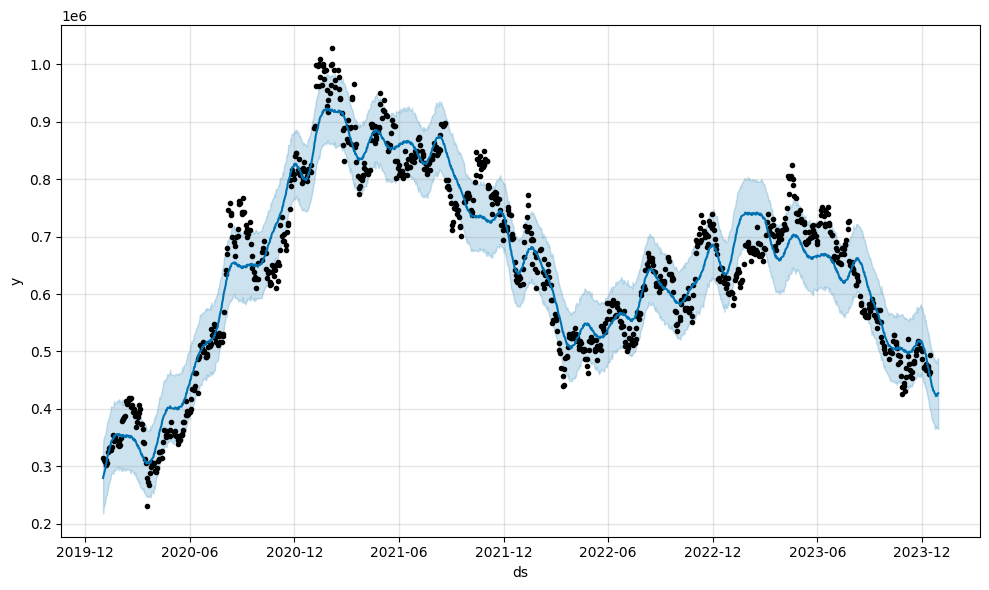

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6i6a_n45/xzij79ct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6i6a_n45/zo0ww1qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52282', 'data', 'file=/tmp/tmp6i6a_n45/xzij79ct.json', 'init=/tmp/tmp6i6a_n45/zo0ww1qf.json', 'output', 'file=/tmp/tmp6i6a_n45/prophet_model4m7ofz9h/prophet_model-20231217130921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


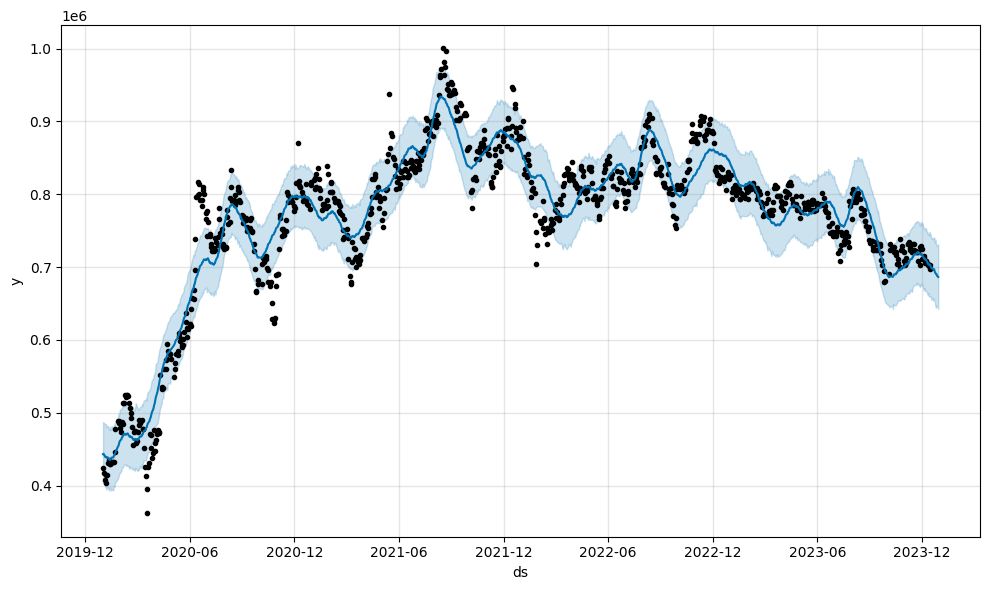

In [15]:
# 예측을 위한 주식 종목 리스트
stock_list = ["삼성전자", "현대차", "LG화학", "POSCO", "삼성바이오로직스"]

forecast_list = []

# 모든 주식 종목에 대한 예측 수행
for stock in stock_list:
    df_stock = get_stock_data(stock, year=2020)
    if df_stock is not None:
        scaled_data = preprocess_data(df_stock)

        # Train Prophet model
        model, forecast = train_prophet_model(df_stock, days_to_predict=14)

        # Plot forecast
        plot_prophet_forecast(model, forecast)

        # Save forecast to dataframe
        forecast_df = save_forecast_to_dataframe(df_stock, forecast, stock)
        forecast_list.append(forecast_df)

In [16]:
forecast_list[0]

,Date,Predicted_Close,Stock
979,2023-12-16,75783.105702,삼성전자
980,2023-12-17,75888.270719,삼성전자
981,2023-12-18,76178.456846,삼성전자
982,2023-12-19,76414.344479,삼성전자
983,2023-12-20,76525.183793,삼성전자
984,2023-12-21,76552.487046,삼성전자
985,2023-12-22,76775.597807,삼성전자
986,2023-12-23,76787.819932,삼성전자
987,2023-12-24,76989.460310,삼성전자
988,2023-12-25,77380.211862,삼성전자


In [17]:
forecast_list[1]

,Date,Predicted_Close,Stock
979,2023-12-16,181090.120270,현대차
980,2023-12-17,180802.093999,현대차
981,2023-12-18,180968.859310,현대차
982,2023-12-19,181395.849661,현대차
983,2023-12-20,181154.549999,현대차
984,2023-12-21,180647.210704,현대차
985,2023-12-22,180447.158112,현대차
986,2023-12-23,180299.891023,현대차
987,2023-12-24,180488.473327,현대차
988,2023-12-25,181178.644616,현대차
